### 线性回归的从零开始实现

In [13]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1  生成数据集

In [14]:
def synthetic_data(weights, bias, num_examples):  # @save
       """生成 y = Xw + b + 噪声"""
       num_features = len(weights)
       X = torch.randn(num_examples, num_features, dtype=torch.float32)  # 生成标准正态分布的特征矩阵X
       y = torch.matmul(X, weights) + bias  # 计算线性部分
       y += torch.randn(y.shape, dtype=torch.float32) * 0.01  # 添加噪声
       return X, y.reshape((-1, 1))  # 返回特征矩阵和标签向量

#生成线性回归真值参数
true_weights = torch.tensor([2, -3, 4], dtype=torch.float32)
true_bias = torch.tensor(4.2, dtype=torch.float32)
features, labels = synthetic_data(true_weights, true_bias, 1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含对应的标签值。


In [15]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 1.3673, -0.0489,  0.2437]) 
label: tensor([8.0666])


通过生成第二个特征features[:,1]和labels的散点图，我们可以直观地观察两者之间的线性关系。

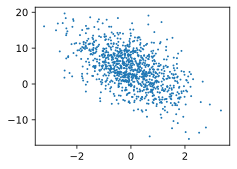

In [16]:
d2l.set_figsize()  
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);

### 3.2.2  读取数据集

我们先打乱数据集中的样本并以小批量方式获取数据。

我们定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，并生成大小为batch_size的小批量。每个小批量包含一组特征和标签

In [17]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

我们可以通过运行以下代码来查看一个小批量中的特征和标签。

In [18]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.5417,  1.4947, -0.2211],
        [ 2.2957, -0.8427, -0.6344],
        [-0.6741, -0.4908, -0.4475],
        [ 0.8484, -0.0102,  2.0394],
        [-1.5422,  0.1052, -2.0481],
        [ 1.1889,  1.8710,  2.0623],
        [-1.0088, -0.4833,  0.6858],
        [-0.7198,  2.7749, -1.6473],
        [-0.2136, -1.1159, -1.6201],
        [-0.2043, -0.9205, -1.0454]]) 
 tensor([[ -4.2512],
        [  8.8052],
        [  2.5180],
        [ 14.1093],
        [ -7.3882],
        [  9.2234],
        [  6.3722],
        [-12.1395],
        [  0.6326],
        [  2.3623]])


### 3.2.3 初始化模型参数

我们通过从均值为0、标准差为0.01的正态分布中抽取随机数来初始化权重。偏置项（bias）设为0。

In [19]:
w = torch.normal(0, 0.01, size=(3, 1), requires_grad=True)  # 权重由均值为0、标准差为0.01的正态分布中抽取随机数
b=torch.zeros(1,requires_grad=True)  #bias=0

### 3.2.4 定义模型

定义模型，将模型的输入和参数同模型的输出关联起来。
回想广播机制：当我们用一个向量加一个标量时，标量会被加到每个向量的分量上。

In [20]:
def linreg(X,w,b):  # @save
    """线性回归模型"""
    return torch.matmul(X,w)+b

### 3.2.5 定义损失函数

In [21]:
def squared_loss(y_hat,y):  # @save
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

### 3.2.6 定义优化算法

In [22]:
def sgd(params, lr, batch_size):  # @save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 训练模型

理解这段代码非常重要，以后深度学习中训练过程几乎一遍一遍德出现。每次迭代中，我们读取小批量训练样本，并通过我们的模型来获得一组预测。计算完损失后，通过反向传播计算所有模型参数的梯度。最后，我们调用sgd函数，将梯度更新到模型参数上。

In [23]:
lr =0.03  # 学习率（超参数）
num_epochs = 3  # 训练周期（迭代周期）超参数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):    # 训练模型一共需要num_epochs个迭代周期
   for X,y in data_iter(batch_size,features,labels):
       l = loss(net(X,w,b),y)  # X和y的mini-batch
       l.sum().backward()     # 损失函数在求关于模型参数的梯度
       sgd([w,b],lr,batch_size) # 使用小批量随机梯度下降迭代模型参数
   with torch.no_grad():
       train_l = loss(net(features,w,b),labels)
       print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.042632
epoch 2, loss 0.000122
epoch 3, loss 0.000044


因为我们使用的是自己合成的数据集，所以我们知道真实的参数是什么。因此，我们可以通过比较真实参数和通过训练学习的参数来评估训练的成功程度。

In [24]:
print(f'w的估计误差: {true_weights - w.reshape(true_weights.shape)}')
print(f'b的估计误差: {true_bias - b}')

w的估计误差: tensor([ 0.0007, -0.0002,  0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<SubBackward0>)
